The proportion of countries per community is  0:47.6%, 1:37.2%, and 2:15.2%. I'm not whether this may affect the results found or is not relevant. To make sure that the result is independent of the relative proportions of countries among the communities found, I believe that one valid option could be to randomly generate labels of three categorical classes to simulate the three communities found and assign a different probability of occurrence of the simulated labels among countries using the original proportion of countries per community. Here I performed this test and found that randomly assigning labels does not yield the same patterns found by using the community detection algorithms.  

In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [20]:
af_ex_pca = pd.read_csv('af_ex_pca.csv',index_col=0)

In [21]:
pivot_afex=af_ex_pca.pivot_table(values='af_ex_pca',columns='country',index='year')
pivot_afex=pivot_afex.drop(columns='Unspecified Area')

In [22]:
pop=pd.read_csv('pairing_data/Population_clean.csv',index_col=0)
gdp = pd.read_csv('pairing_data/GDP_clean.csv',index_col=0)
distance = pd.read_csv('pairing_data/for_distance_pairing/distances_year_ex_im.csv',index_col=0) # distances in Km
df_communities = pd.read_csv('community_countries.csv',index_col=0)

In [23]:
df_communities['labels'] = np.random.choice([0,1,2],size=df_communities.shape[0],p=[0.476190,0.371429,0.152381])
mergd_afex_communities = pivot_afex.T.merge(df_communities,on='country')    

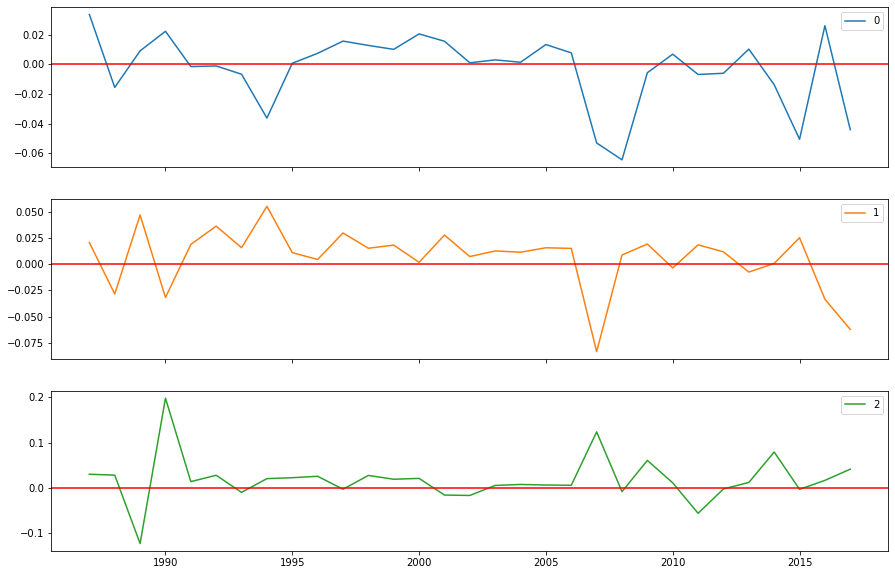

In [24]:
ax=mergd_afex_communities.groupby('labels').median().T.plot(subplots=True,figsize=(15,10))
ax[0].axhline(0,c='red')
ax[1].axhline(0,c='red')
ax[2].axhline(0,c='red')

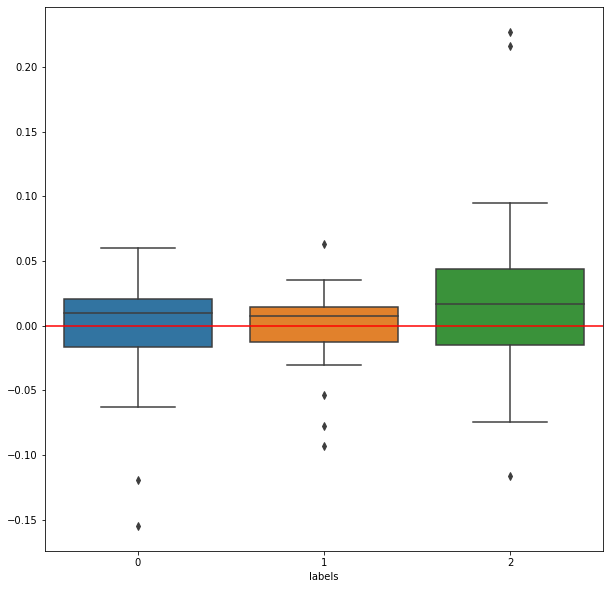

In [28]:
fig,axs=plt.subplots(1,1,figsize=(10,10))

sns.boxplot(data=mergd_afex_communities.groupby('labels').mean().T,ax=axs)
_=axs.axhline(0,c='red')

In [25]:
merged_pop_communities = pop.merge(df_communities,how='inner',left_on='country.value',right_on='country').drop(columns='country.value',axis=1)
merged_gdp_communities = gdp.merge(df_communities,how='inner',left_on='country.value',right_on='country').drop(columns='country.value',axis=1)
merged_pop_communities = merged_pop_communities[['date','value','country','labels']]
merged_gdp_communities = merged_gdp_communities[['date','value','country','labels']]

merged_distances_ex_communities = distance.groupby(['exporter','Year']).sum().reset_index().merge(df_communities,how='inner',left_on='exporter',right_on='country').drop(columns='exporter',axis=1)
merged_distances_in_communities = distance.groupby(['importer','Year']).sum().reset_index().merge(df_communities,how='inner',left_on='importer',right_on='country').drop(columns='importer',axis=1)

Text(0.5, 1.0, 'Population')

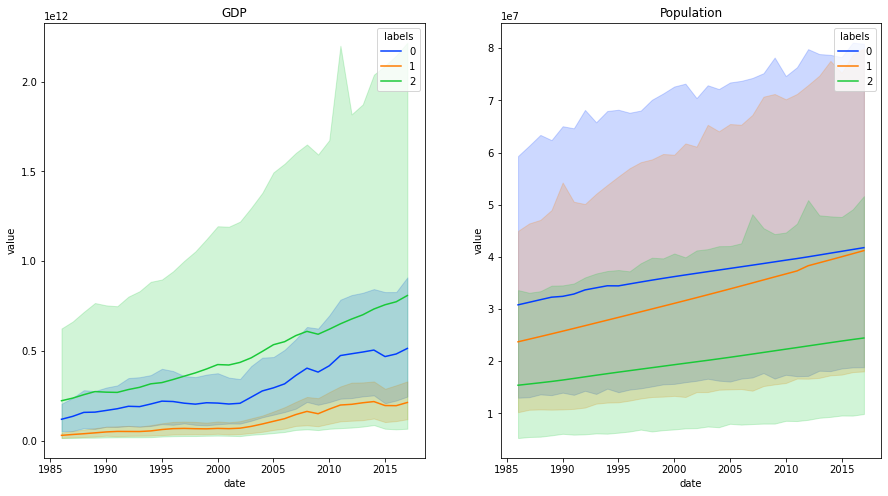

In [26]:
fig,axs=plt.subplots(1,2,figsize=(15,8))
a=sns.lineplot(data=merged_gdp_communities,y='value',x='date',hue='labels',ax=axs[0],palette='bright',hue_order=[0,1,2])
b=sns.lineplot(data=merged_pop_communities[['date','value','country','labels']],y='value',x='date',hue='labels',ax=axs[1],palette='bright',hue_order=[0,1,2])
axs[0].set_title('GDP')
axs[1].set_title('Population')

In [29]:
parametric_plot=merged_distances_ex_communities.groupby(['Year','labels']).mean().reset_index().merge(
    mergd_afex_communities.groupby('labels').mean().T.reset_index().melt(id_vars='index',value_name='antifragility').rename({'index':'Year'},axis=1),on=['Year','labels'])

Text(0.5, 0, 'exportation distances')

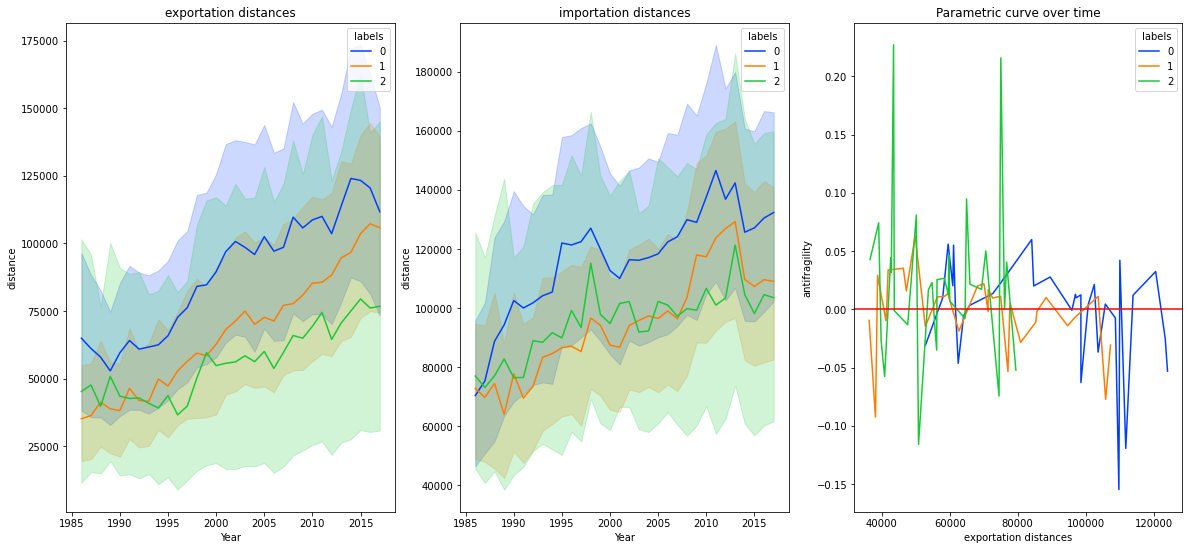

In [32]:
fig,axs=plt.subplots(1,3,figsize=(20,9)) # 2.8
sns.lineplot(data=merged_distances_ex_communities,y='distance',x='Year',hue='labels',hue_order=df_communities['labels'].unique(),ax=axs[0],palette='bright')
sns.lineplot(data=merged_distances_in_communities,y='distance',x='Year',hue='labels',hue_order=df_communities['labels'].unique(),ax=axs[1],palette='bright')
sns.lineplot(data=parametric_plot,x='distance',y='antifragility',hue='labels',palette='bright',hue_order=[0,1,2])
axs[2].axhline(0,c='red')
axs[0].set_title('exportation distances')
axs[1].set_title('importation distances')
axs[2].set_title('Parametric curve over time')
axs[2].set_xlabel('exportation distances')

In [28]:
# fig,axs=plt.subplots(2,2,figsize=(15,8))
# sns.boxplot(data=merged_gdp_communities.groupby(['date','labels']).mean().reset_index().pivot_table(index='date',columns='labels'),ax=axs[0,0])
# sns.boxplot(data=merged_pop_communities.groupby(['date','labels']).mean().reset_index().pivot_table(index='date',columns='labels'),ax=axs[0,1])
# sns.boxplot(data=merged_distances_ex_communities.groupby(['Year','labels']).mean().reset_index().pivot_table(index='Year',columns='labels'),ax=axs[1,0])
# sns.boxplot(data=merged_distances_in_communities.groupby(['Year','labels']).mean().reset_index().pivot_table(index='Year',columns='labels'),ax=axs[1,1])